# Problem 4

## Load and clean libraries and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, Lasso
from sklearn.model_selection import cross_val_score

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

def rmse_cv(model, log=False):
    if log == True:
        rmse= np.sqrt(-cross_val_score(model, X_train_log, y_log, scoring="neg_mean_squared_error", cv = 5))
        return(rmse)
    else:
        rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
        return(rmse)

def makePlot(cv_model, alphas, line=True):
    plt.figure(figsize = (10,8))
    _ = plt.plot(alphas, cv_model[0,:], marker='.', label = solvers[0])
    _ = plt.plot(alphas, cv_model[1,:], marker=',', label = solvers[1])
    _ = plt.plot(alphas, cv_model[2,:], marker='o', label = solvers[2])
    plt.xlabel("Alpha", fontsize=12)
    plt.ylabel("RMSE", fontsize=12)
    #if line == True:
        #xposition = alphas[np.argmin(cv_model[0,:])]
        #plt.axvline(x=xposition, color='k', linestyle='--')
        #plt.text(xposition + 0.08, 0.1375, 'Minimum Alpha', rotation=0)
    _ = plt.title("Alpha vs. RMSE for different Alphas, Solvers", fontsize=15)
    _ = plt.legend()

In [2]:
# Load data, create regular data and logspace data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

################################################################
# Create log space data
################################################################


train_log = train.copy()
test_log = test.copy()

# all_data is the original clean data
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

all_data_log = all_data.copy()
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})

#log transform the target:
train_log["SalePrice"] = np.log1p(train_log["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data_log[skewed_feats] = np.log1p(all_data[skewed_feats])
all_data_log = pd.get_dummies(all_data_log)

#filling NA's with the mean of the column:
all_data_log = all_data_log.fillna(all_data_log.mean())
smaller_data_log = all_data_log.loc[:, ['OverallQual', 'YearRemodAdd', 
                                'YearBuilt', '1stFlrSF', 'GarageArea', 
                                'GrLivArea']]

#creating matrices for part 1 (with all columns):
X_train_log_orig = all_data_log[:train.shape[0]]
X_test_log_orig = all_data_log[train.shape[0]:]
# note these are non log space 
y_log_orig = train_log.SalePrice

#creating matrices for sklearn:
X_train_log = smaller_data_log[:train.shape[0]]
X_test_log = smaller_data_log[train.shape[0]:]
y_log = train.SalePrice

####################################################################
# Create non-log data set
###################################################################
all_data = pd.get_dummies(all_data)
smaller_data = all_data.loc[:, ['OverallQual', 'YearRemodAdd', 
                                'YearBuilt', '1stFlrSF', 'GarageArea', 
                                'GrLivArea']]
# Clean zeros and NaN
smaller_data.isnull().sum()
smaller_data = smaller_data.fillna(0)
smaller_data.isnull().sum()

#creating matrices for sklearn:
X_train = smaller_data[:train.shape[0]]
X_test = smaller_data[train.shape[0]:]
y = train.SalePrice

#### Check correlation of prepared data

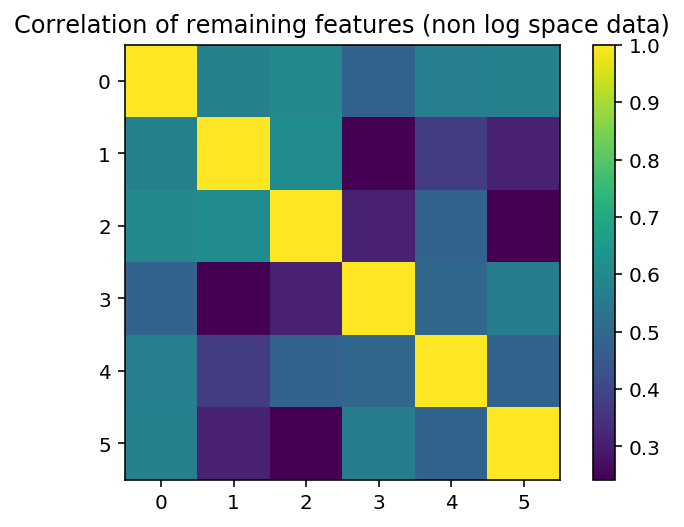

In [3]:
fig, ax = plt.subplots()
plt.imshow(smaller_data.corr())
_ = plt.colorbar()
_ = plt.title('Correlation of remaining features (non log space data)')
#_ = ax.set_xticks(smaller_data.columns.values)
#_ = ax.set_yticklabels(smaller_data.columns.values)

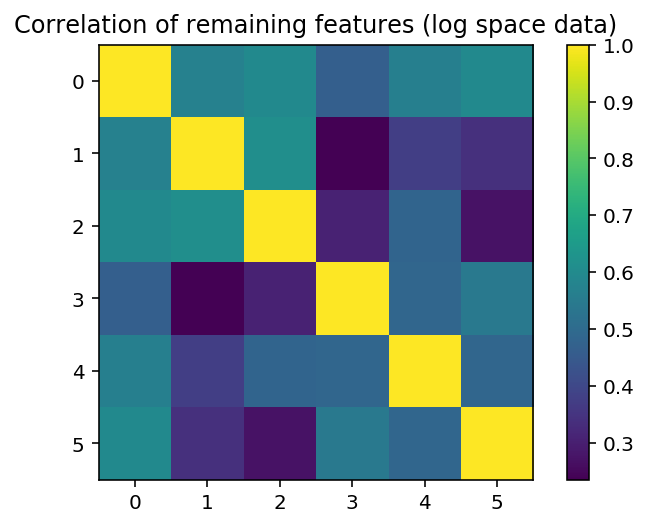

In [4]:
fig, ax = plt.subplots()
plt.imshow(smaller_data_log.corr())
_ = plt.colorbar()
_ = plt.title('Correlation of remaining features (log space data)')
#_ = ax.set_xticks(smaller_data.columns.values)
#_ = ax.set_yticklabels(smaller_data.columns.values)

## Testing different solvers, alphas, and models

### Ridge Regression (Modified)

In [5]:
###########################################################
# Test different solvers and alphas for Ridge Regression
##########################################################
solvers = ['svd', 'cholesky', 'lsqr']
num_alphas = 11
alphas_1 = [0.001*1.5**x for x in range(num_alphas)]

cv_ridge_1 = [[rmse_cv(Ridge(alpha = alpha, normalize=True, solver= solver)).mean() 
            for alpha in alphas_1] for solver in solvers]
cv_ridge_1 = np.array(cv_ridge_1)

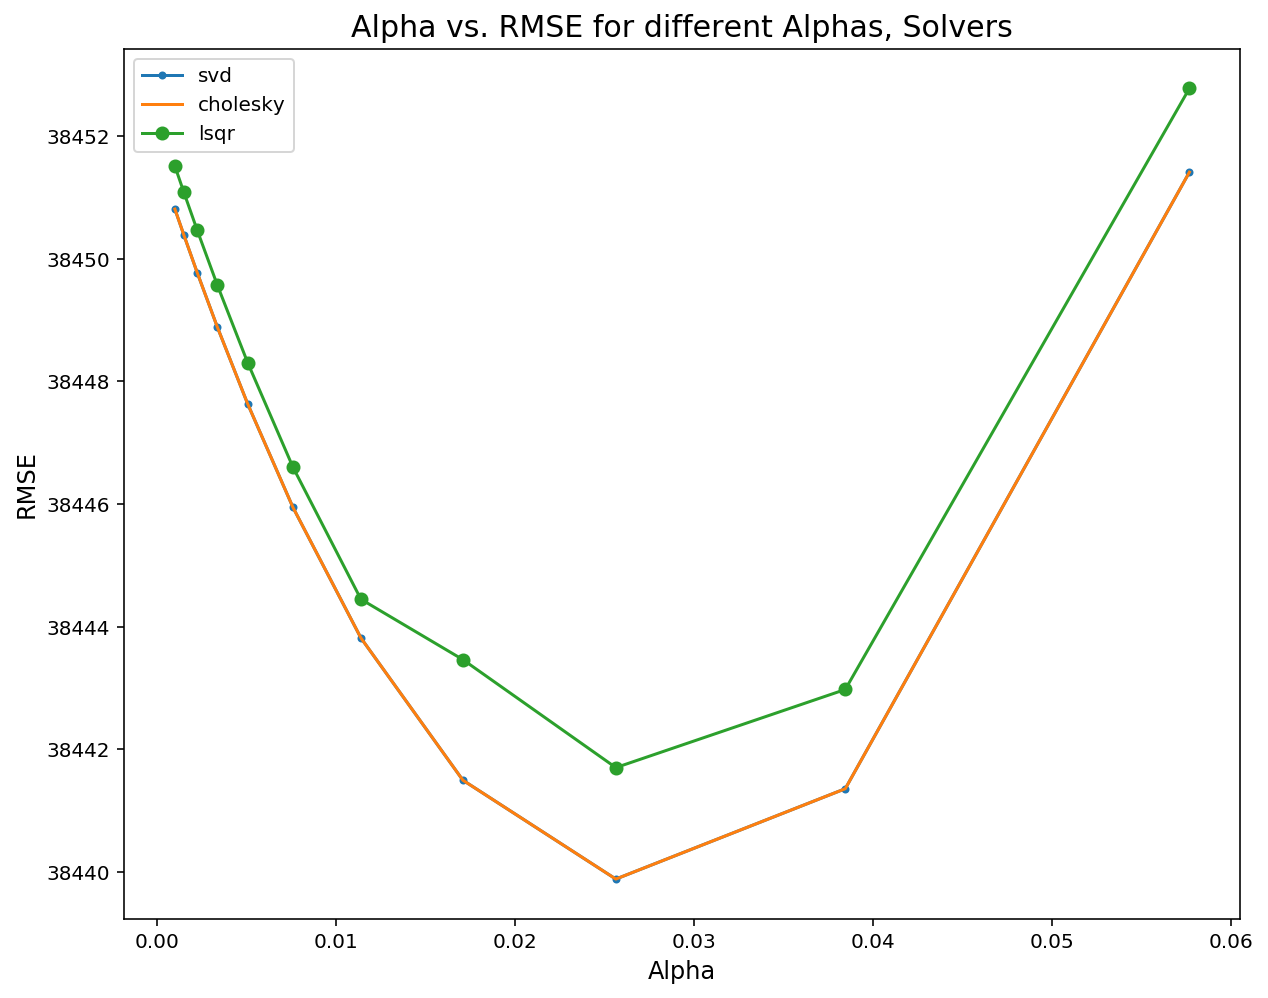

In [6]:
makePlot(cv_ridge_1, alphas_1)

In [7]:
###########################################################
# Zoom in on alphas
##########################################################
solvers = ['svd', 'cholesky', 'lsqr']
num_alphas_2 = 18
alphas_2 = np.arange(0.02, 0.04, 0.001)

cv_ridge_2 = [[rmse_cv(Ridge(alpha=alpha, normalize=True, solver= solver)).mean() 
            for alpha in alphas_2] for solver in solvers]
cv_ridge_2 = np.array(cv_ridge_2)

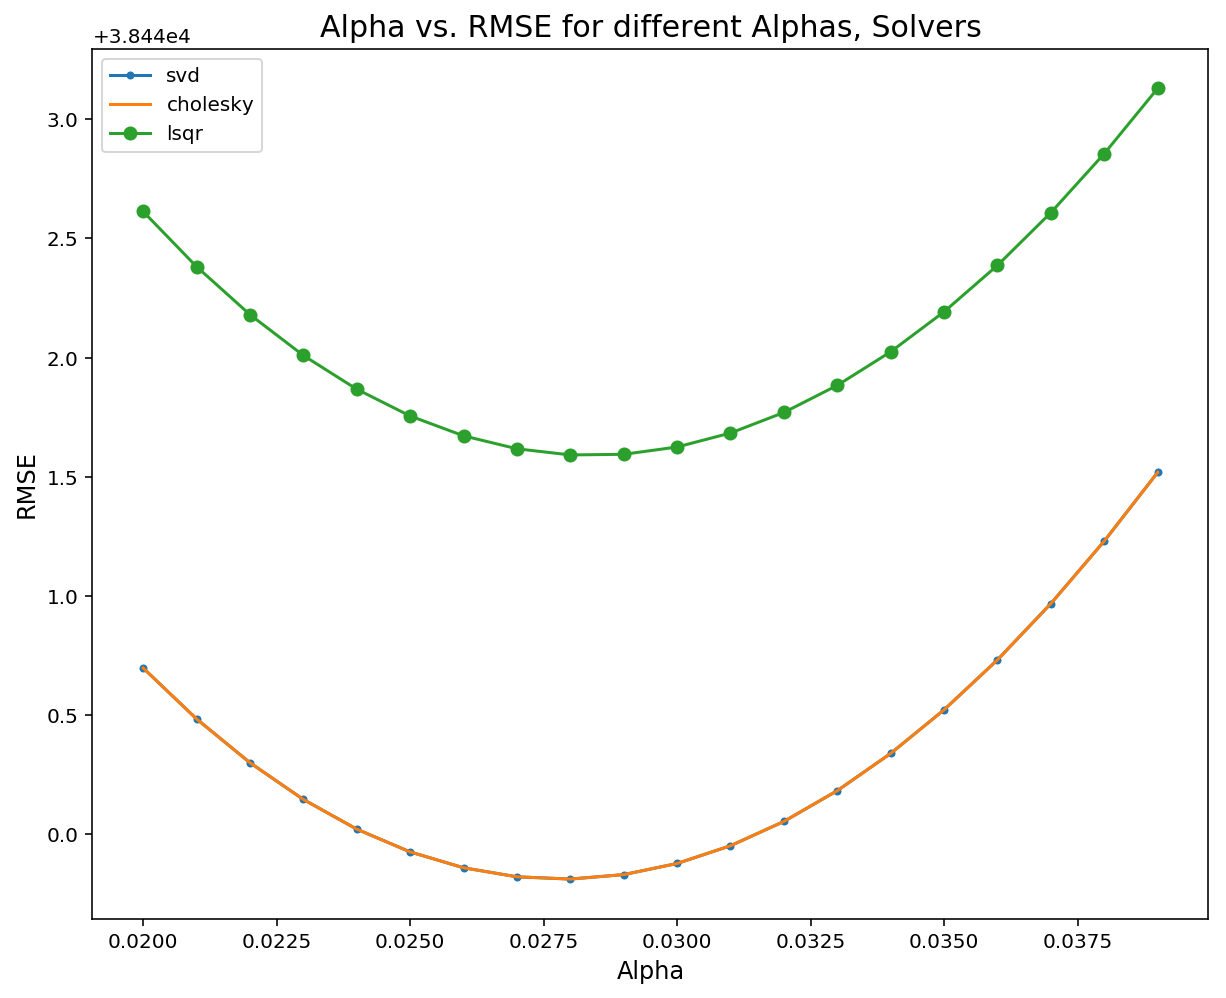

In [8]:
makePlot(cv_ridge_2, alphas_2)

#### Make Ridge predictions and write to file

In [9]:
l2_reg = alphas_2[np.argmin(cv_ridge_2[1,:])]
print(l2_reg)

0.028000000000000008


In [10]:
# We can see alpha value 0.28 gives us the lowest error
model_ridge = Ridge(alpha=0.28, normalize=True)
model_ridge.fit(X_train, y)
_ = model_ridge.predict(X_test)
new_index = np.arange(1461,2920,1)
index = pd.DataFrame(new_index, columns=['Id'])
y_hat = pd.DataFrame(_, columns=['SalePrice'])
frames = [index, y_hat]
pred = pd.concat(frames, axis=1)
pred.head()

,Id,SalePrice
0,1461,130966.838287
1,1462,155596.371077
2,1463,172261.040075
3,1464,187505.863397
4,1465,217125.799041


In [11]:
filename = 'prediction-ridge.csv'
pred.to_csv(filename, encoding='utf-8', index=False)

### Lasso Model (Modified)

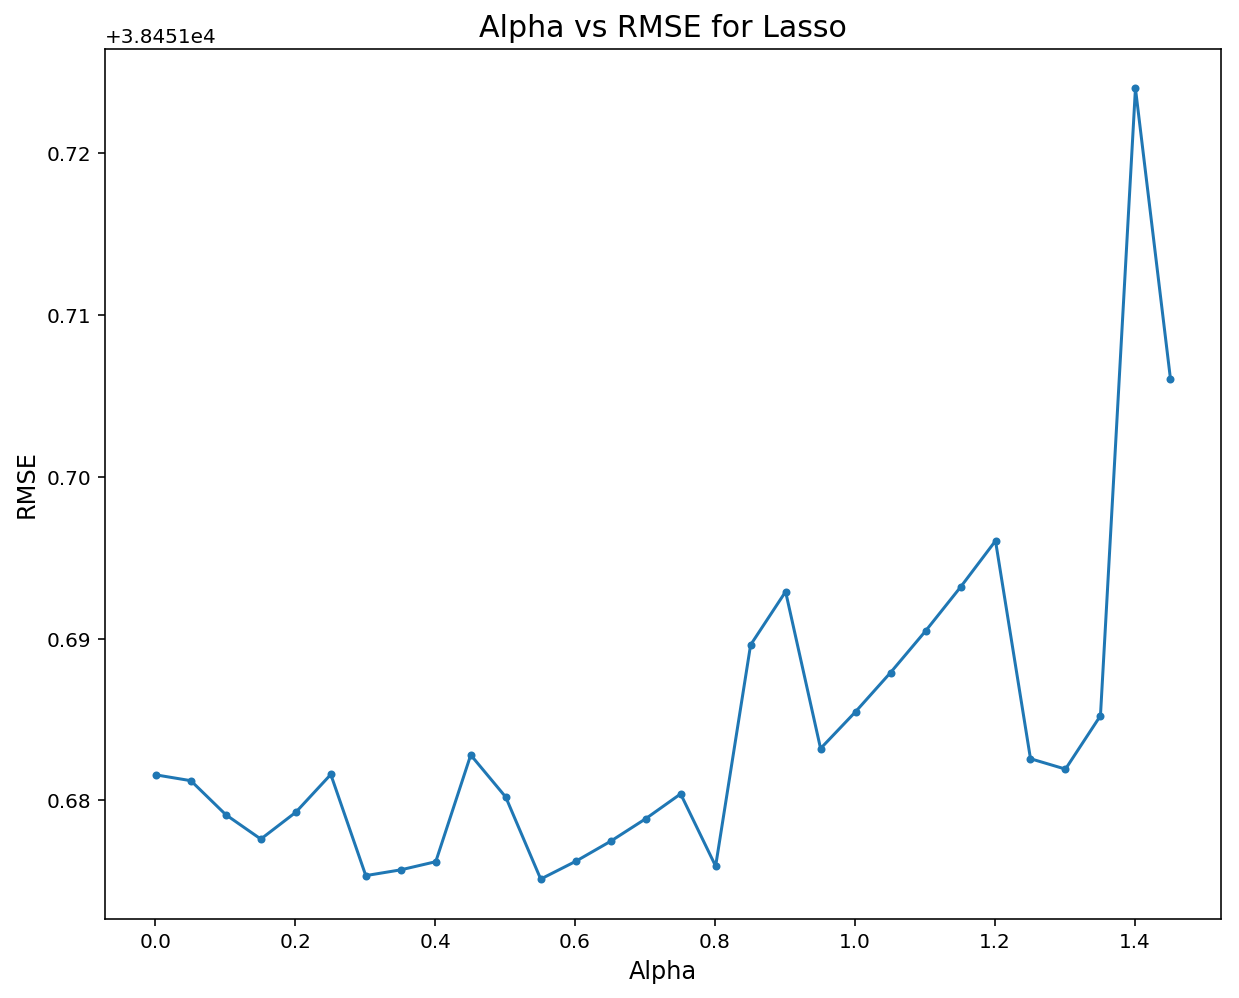

In [12]:
###########################################################
# Test different alphas for Lasso Regression
##########################################################
alphas_3 = np.arange(0.001, 1.5, 0.05)

cv_lasso = [rmse_cv(Lasso(alpha=alpha,normalize = True)).mean() 
            for alpha in alphas_3]
cv_lasso = np.array(cv_lasso)

plt.figure(figsize = (10,8))
_ = plt.plot(alphas_3, cv_lasso, marker='.')
plt.xlabel("Alpha", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
_ = plt.title("Alpha vs RMSE for Lasso", fontsize=15)

#### Make Lasso predictions and write to file

In [13]:
l1_reg = alphas_3[np.argmin(cv_lasso)]
print(l1_reg)

0.551


In [14]:
model_lasso = Lasso(alpha=0.551, normalize=True)
model_ridge.fit(X_train_log, y_log)
y_hat = model_ridge.predict(X_test_log)
new_index = np.arange(1461,2920,1)
index = pd.DataFrame(new_index, columns=['Id'])
y_hat = pd.DataFrame(y_hat, columns=['SalePrice'])
frames = [index, y_hat]
pred = pd.concat(frames, axis=1)
pred.head()

,Id,SalePrice
0,1461,129352.816565
1,1462,160894.119226
2,1463,174019.166295
3,1464,189935.955202
4,1465,222995.982704


In [15]:
pred.loc[pred["SalePrice"] < 0, "SalePrice"] = pred["SalePrice"].mean()
print(pred[pred["SalePrice"]<0])

Empty DataFrame
Columns: [Id, SalePrice]
Index: []


In [16]:
filename = 'prediction-lasso.csv'
pred.to_csv(filename, encoding='utf-8', index=False)

## Plot $L^0$ Norm

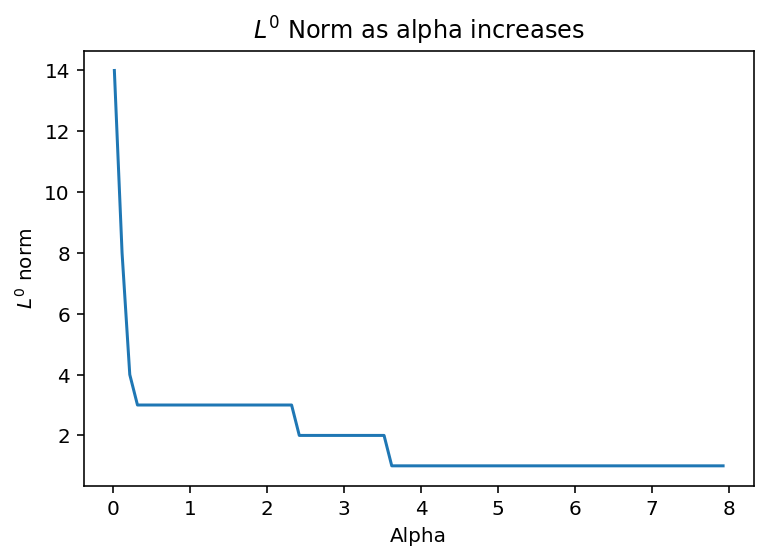

In [17]:
alphas_4 = np.arange(0.02, 8, 0.1)
nonzero = []
coeffs = []
for alpha in alphas_4:
    model = Lasso(alpha= alpha)
    model.fit(X_train_log_orig, y_log_orig)
    coeffs = model.coef_
    nonzero.append(len([coeff for coeff in coeffs if coeff != 0]))
    
plt.plot(alphas_4, nonzero)
plt.xlabel("Alpha")
plt.ylabel("$L^0$ norm")
_ = plt.title("$L^0$ Norm as alpha increases")
plt.show()

## XGBoost

In [18]:
boosters = ['gbtree', 'gblinear', 'dart']
etas = np.arange(0.001, 0.8, 0.01)

cv_xgboost = [[rmse_cv(XGBRegressor(learning_rate=eta, booster=booster)).mean() 
            for eta in etas] for booster in boosters]

cv_xgboost = np.array(cv_xgboost)

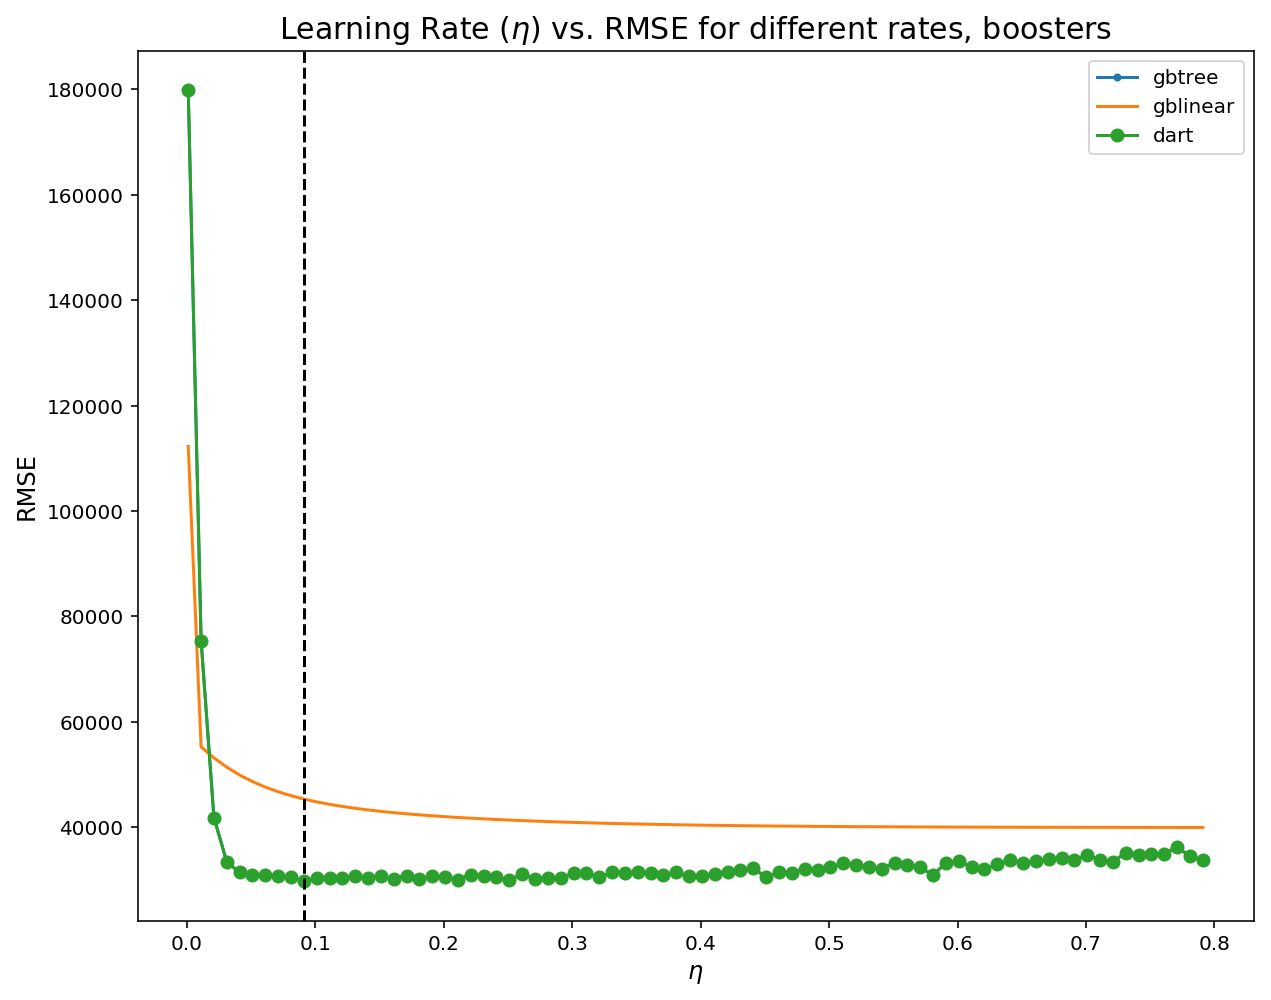

In [19]:
plt.figure(figsize = (10,8))
_ = plt.plot(etas, cv_xgboost[0,:], marker='.', label = boosters[0])
_ = plt.plot(etas, cv_xgboost[1,:], marker=',', label = boosters[1])
_ = plt.plot(etas, cv_xgboost[2,:], marker='o', label = boosters[2])
plt.xlabel("$\eta$", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
xposition = etas[np.argmin(cv_xgboost[2,:])]
plt.axvline(x=xposition, color='k', linestyle='--')
        #plt.text(xposition + 0.08, 0.1375, 'Minimum Alpha', rotation=0)
_ = plt.title("Learning Rate ($\eta$) vs. RMSE for different rates, boosters", fontsize=15)
_ = plt.legend()

In [20]:
boosters = ['gbtree', 'dart']
etas = np.arange(0.01, 0.2, 0.01)

cv_xgboost = [[rmse_cv(XGBRegressor(learning_rate=eta, booster=booster)).mean() 
            for eta in etas] for booster in boosters]

cv_xgboost = np.array(cv_xgboost)

0.12


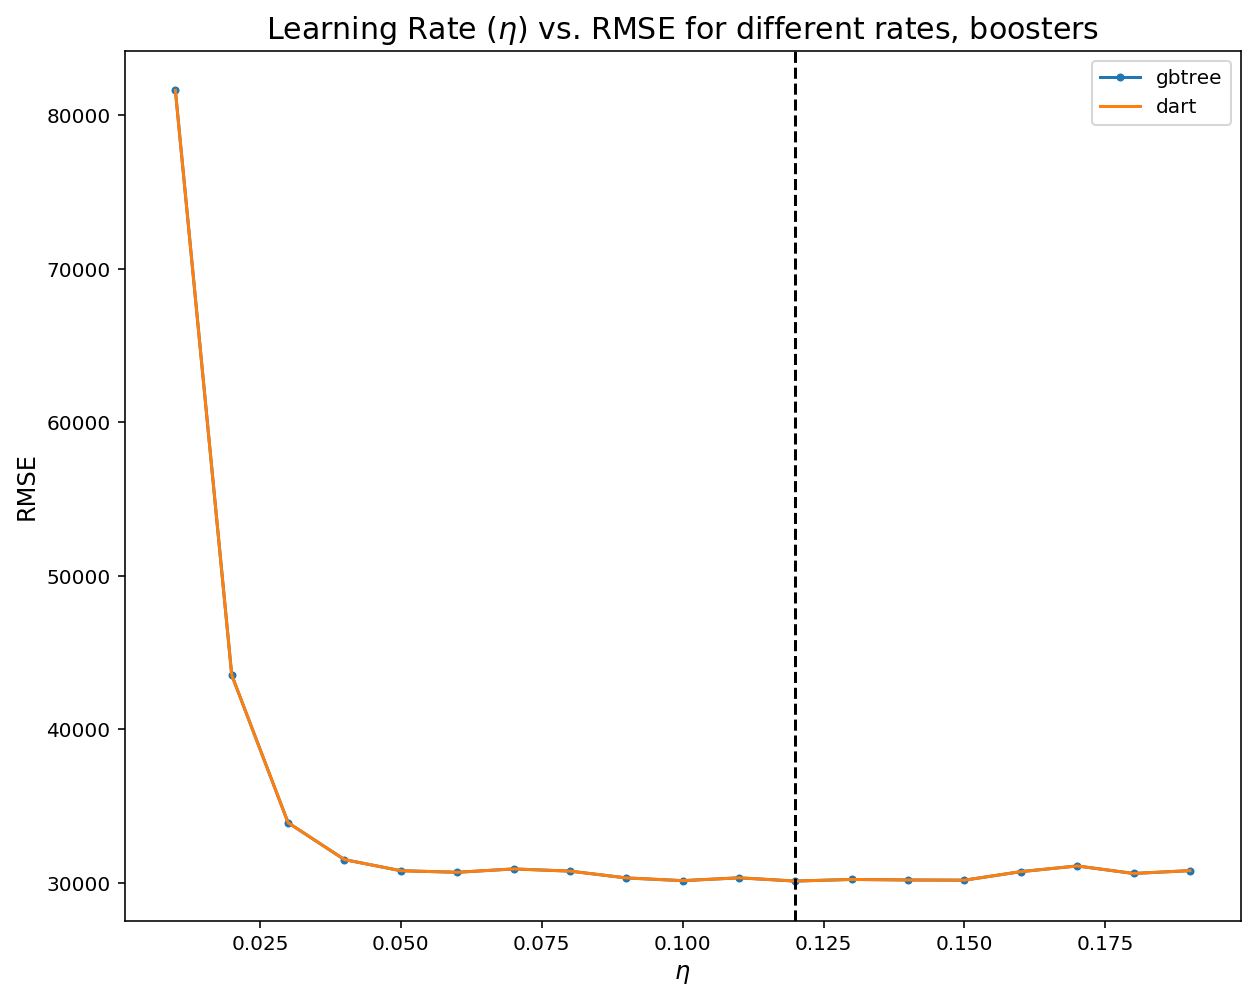

In [21]:
plt.figure(figsize = (10,8))
_ = plt.plot(etas, cv_xgboost[0,:], marker='.', label = boosters[0])
_ = plt.plot(etas, cv_xgboost[1,:], marker=',', label = boosters[1])
plt.xlabel("$\eta$", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
xposition = etas[np.argmin(cv_xgboost[1,:])]
plt.axvline(x=xposition, color='k', linestyle='--')
        #plt.text(xposition + 0.08, 0.1375, 'Minimum Alpha', rotation=0)
_ = plt.title("Learning Rate ($\eta$) vs. RMSE for different rates, boosters", fontsize=15)
_ = plt.legend()
print(xposition)

In [22]:
model = XGBRegressor(learning_rate=0.12, booster='dart')
_ = model.fit(X_train, y)

In [23]:
_ = model.predict(X_test)
new_index = np.arange(1461,2920,1)

index = pd.DataFrame(new_index, columns=['Id'])
y_hat = pd.DataFrame(_, columns=['SalePrice'])
frames = [index, y_hat]
pred = pd.concat(frames, axis=1)
pred.head()

,Id,SalePrice
0,1461,129776.914062
1,1462,141023.125000
2,1463,163525.484375
3,1464,178384.703125
4,1465,208871.890625


In [24]:
filename = 'prediction-xgb.csv'
pred.to_csv(filename, encoding='utf-8', index=False)

## Ensemble and Stacking

In [25]:
# Build base model
model_ridge_2 = Ridge(alpha=0.01899, normalize=True)
model_ridge_2.fit(X_train, y)
y_hat_2 = model_ridge_2.predict(X_train)

In [27]:
## Feed the base model back into another Ridge
y_hat_2 = pd.DataFrame(y_hat_2, columns=['Ridge'])
frames = [X_train, y_hat_2]
X_train_stacked = pd.concat(frames,axis =1)
_ = model_ridge_2.fit(X_train_stacked,y)

# append ones for the new column
ones = pd.DataFrame(np.ones((1459)))
frames = [X_test, ones]
X_test_stacked = pd.concat(frames, axis=1)
y_hat_3 = model_ridge_2.predict(X_test_stacked)

In [28]:
filename = 'prediction-stacked.csv'
pred.to_csv(filename, encoding='utf-8', index=False)

#### Best Scores
<ul>
    <li>Ridge: 0.16355</li>
    <li>Lasso: 0.25405</li>
    <li>XGB: 0.16584</li>
    <li>Ensemble: 0.25405 </li>
</ul>